# Sentiment Analysis Notebook

Sentiment analysis notebook with a simple RNN by Basel.

## 1. Includes

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as reg

# NLP refs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# THE BIG GUNS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam


# Eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report



pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Dataset info

In [2]:
splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
df = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
df_val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])

## Add val data

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset shape: (31232, 4)

First few rows:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in the widget?,1,neutral
2,17697,"I love the humor, I just reworded it. Like saying 'group therapy' instead`a 'gang banging'. Kee...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [3]:
print("nulls:")
df.isnull().sum()

nulls:


,0
id,0
text,0
label,0
sentiment,0


In [4]:
# df['label'].value_counts()

In [5]:
print("has links?")
df[df['text'].str.contains('https?')].head()

has links?


,id,text,label,sentiment
21,14653,(bye) plurk out muna. will be back when im done reading the book http://plurk.com/p/rq9c7,1,neutral
24,2900,http://twitpic.com/3ernb - Loving The Jumper,2,positive
54,19253,Download movie 'Ben 10: Alien Force' http://tinyurl.com/czb7b2 cool #movie,2,positive
64,172,URL in previous post (to timer job) should be http://bit.ly/a4Fdb. I`d removed space which messe...,0,negative
102,13643,_nicole http://twitpic.com/4t6qx - i have the exact same pic except it`s my hubby & my chihuahua...,2,positive


In [6]:
print("all english letters?")
df[df['text'].str.contains('[^\x00-\x7F]')].head()

all english letters?


,id,text,label,sentiment
91,6059,"The app is great, and I´ve started to use it rather than wunderlist. Just 3 stars because I don´...",1,neutral
174,8112,"💩👎💩👎💩👎💩 👻☠️ IMPOSSIBLE TO DELETE LIST, OR SUB LISTS (TABS)!!! ☠️👻 REGRET v2.0 UPGRADE!! 👎💩👎💩👎💩👎💩...",0,negative
185,4095,Es muy útil para mantener las aplicaciones del celular cerradas mientras trabajas.,2,positive
241,2091,the app and widɡet are very ɡood. Will change to 5 start when I can be able to add task using go...,1,neutral
414,26054,"ohhhh, how sad...I didnï¿½t get it!",0,negative


## 3. The Prep Kitchen (Preprocessing)

In [7]:
def cleaner(text):
    text = text.lower()
    text = reg.sub(r'<[^>]*>', '',text)
    text = reg.sub(r'http\S+|www\S+|https\S+', '', text)
    text = reg.sub(r'@\w+', '', text)
    text = reg.sub(r'[^a-zA-Z\s]', '', text)
    text = reg.sub(r'\s+', ' ', text).strip()
    return text
df['cleaned_text'] = df['text'].apply(cleaner)
df_val['cleaned_text'] = df_val['text'].apply(cleaner)
print("Any stragglers?")
df[df['cleaned_text'].str.contains('[^\x00-\x7F]')].head()

# Remove emojis check emoji !


Any stragglers?


,id,text,label,sentiment,cleaned_text


In [8]:
def preprocesser(text):
    # tokenize
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # stem
    lemmy = WordNetLemmatizer()
    lemmy_tokens = [lemmy.lemmatize(token) for token in tokens]

    processed_text = ' '.join(lemmy_tokens)

    return processed_text

df['processed_text'] = df['cleaned_text'].apply(preprocesser)
df_val['processed_text'] = df_val['cleaned_text'].apply(preprocesser)
df['processed_text'].head()

,processed_text
0,cooking microwave pizza yummy
1,plan allowing sub task show widget
2,love humor reworded like saying group therapy insteada gang banging keep mom back hahaha
3,naw idk ur talkin
4,suck hear hate day like


In [9]:
print("Drop rows where cleanning led to clearing")
df['processed_text'].replace('',np.nan)
df['final_text'] = df['processed_text'].dropna()
df_val['final_text'] = df_val['processed_text'].dropna()

Drop rows where cleanning led to clearing


## 4. Divorcing the dataset (Splitting)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['final_text'], df['label'], test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


X_val = df_val['final_text']
y_val = df_val['label']

Training set shape: (24985,)
Testing set shape: (6247,)


## 5. CBOWing and stuff (Tokenization/Padding)

In [11]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
max_len = max(len(tokens) for tokens in train_sequences)



X_train_padded = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
X_val_padded = pad_sequences(val_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')

# print("Original text:", X_train[0])
X_train.head()
print("Tokenized sequence:", train_sequences[0])
print("Shape of padded sequences:", X_train_padded.shape)
print("Example of padded sequence:", X_train_padded[0])

Tokenized sequence: [77, 1, 374, 160, 24, 111, 1]
Shape of padded sequences: (24985, 197)
Example of padded sequence: [ 77   1 374 160  24 111   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## 6. ***IT'S ALIVE*** (Training)

In [17]:
# Params
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 150

# The real deal
model = Sequential([
    Embedding(vocab_size, output_dim = embedding_dim),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=False)),
    # Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)




early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.00085,
    mode='min',
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001
)



history = model.fit(
    X_train_padded,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]

)
model.summary()

Epoch 1/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.5210 - loss: 0.9497 - val_accuracy: 0.6683 - val_loss: 0.7733 - learning_rate: 0.0010
Epoch 2/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.6731 - loss: 0.7641 - val_accuracy: 0.6821 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 3/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.6890 - loss: 0.7381 - val_accuracy: 0.6962 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 4/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.6995 - loss: 0.7040 - val_accuracy: 0.7091 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 5/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.7068 - loss: 0.6829 - val_accuracy: 0.7036 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 6/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 74s 50ms/step - accuracy: 0.7143 - loss: 0.6695 - val_accuracy: 0.7244 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 7/15
781/781 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.7256 - l

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 197, 150)            │       3,505,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 197, 256)            │         285,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,891,549 (45.36 MB)

 Trainable params: 3,963,849 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,927,700 (30.24 MB)

## 7. Is he reaally tho? (Eval)

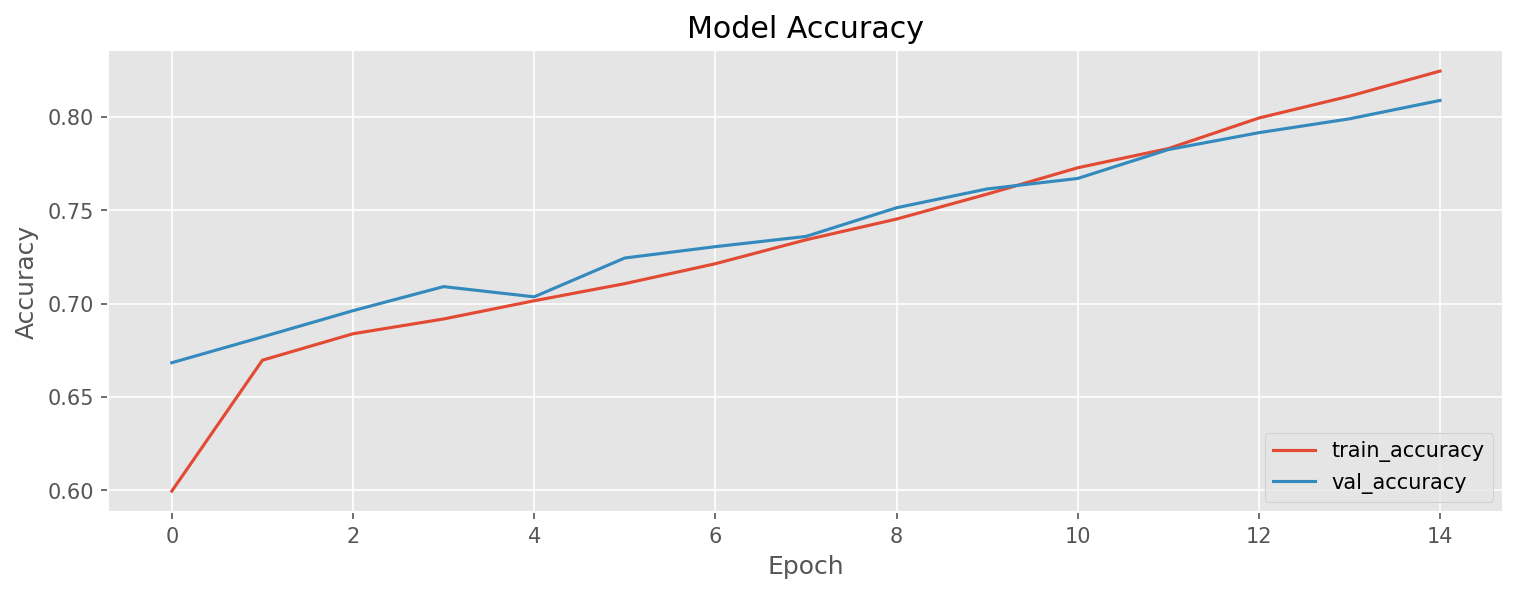

In [18]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
# Get model predictions (probabilities)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
y_probs = model.predict(X_test_padded)
# Print predicted probabilities for the first few negative samples (early problem with suppresed negatives)
negative_indices = np.where(y_test == 0)[0]  # Assuming index 0 is 'negative'
print("Negative Sample Probabilities:\n", y_probs[negative_indices[:5]])
y_pred = np.argmax(y_probs, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Negative Sample Probabilities:
 [[9.6846575e-01 3.1375881e-02 1.5836603e-04]
 [2.7255710e-02 9.7274315e-01 1.1328029e-06]
 [8.9264405e-04 6.5350835e-04 9.9845386e-01]
 [6.9586879e-01 2.3939638e-01 6.4734831e-02]
 [2.3746456e-01 5.3381342e-01 2.2872201e-01]]


In [20]:
# Evaluate
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6485 - loss: 1.2087
Loss: 1.236815333366394, Accuracy: 0.6350247859954834


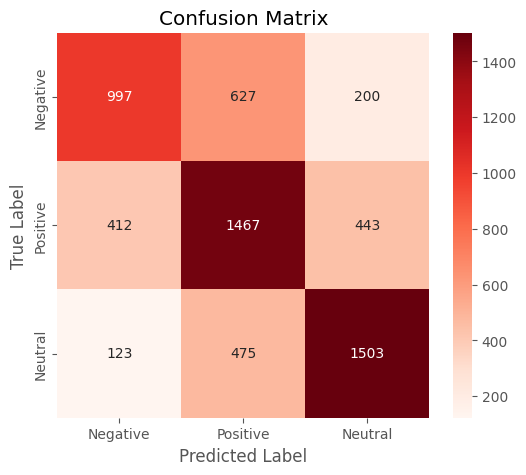

In [21]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test,y_pred ), annot=True, fmt="d", cmap="Reds", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 8. Carving it all into stone (Saving)

In [23]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

model.save("Sentiment_analysis.keras")